In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline

train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])

print(train.shape, test.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1)
{'author'}


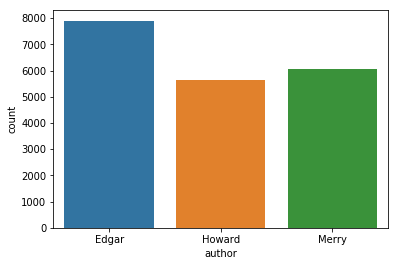

In [3]:
train.author = train.author.replace(['EAP', 'HPL', 'MWS'], ['Edgar', 'Howard', 'Merry'])
sns.countplot(data=train, x='author');

In [4]:
all_words = {
    'Edgar': train[train.author == 'Edgar']['text'].str.split(expand=True).unstack().value_counts(),
    'Howard': train[train.author == 'Howard']['text'].str.split(expand=True).unstack().value_counts(),
    'Merry': train[train.author == 'Merry']['text'].str.split(expand=True).unstack().value_counts()
}

for author_name, all_words_by_author in all_words.items():
    print(author_name)
    print('\nНай-чести думи: ')
    print(all_words_by_author.head())
    print('\nНай-редки думи: ')
    print(all_words_by_author.tail())
    print('\n\n')

Merry

Най-чести думи: 
the    9039
of     6129
and    5929
to     4771
I      4155
dtype: int64

Най-редки думи: 
potion            1
secession         1
sentence,         1
slumbers,         1
precipitation.    1
dtype: int64



Howard

Най-чести думи: 
the    10330
and     5908
of      5792
a       3230
to      3219
dtype: int64

Най-редки думи: 
Protestantism    1
groping.         1
recovery,        1
Little           1
dissolution.     1
dtype: int64



Edgar

Най-чести думи: 
the    13927
of      8930
and     5222
to      4625
a       4514
dtype: int64

Най-редки думи: 
Leonville,    1
heavy;        1
guest         1
Txld          1
"monstrum     1
dtype: int64





In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(len(stopwords))
print(stopwords)

params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

params_count_char = {"features__ngram_range": [(1,4), (1,5), (1,6)],
                      "features__analyzer": ['char'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

    


153
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',

In [6]:
random_search()
pipeline = Pipeline([
    ('features', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

Model with rank: 1
Mean validation score: -0.467 (std: 0.004)
Parameters: {'clf__alpha': 0.1, 'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__max_df': 0.6, 'features__analyzer': 'word', 'features__min_df': 5, 'features__lowercase': False}

Model with rank: 2
Mean validation score: -0.469 (std: 0.001)
Parameters: {'clf__alpha': 0.01, 'features__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 

In [7]:
pipeline.steps[0][1]


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

# nltk.download('punkt')
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
#                                  stop_words=stopwords.words('english') + list(string.punctuation))),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

[ 0.84129902  0.84829911  0.8456705 ]
[-0.39106583 -0.38602577 -0.38741785]


In [ ]:
def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)
random_search()

Model with rank: 1
Mean validation score: -0.421 (std: 0.003)
Parameters: {'clf__alpha': 0.1, 'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__max_df': 0.7, 'features__analyzer': 'word', 'features__min_df': 2, 'features__lowercase': True}

Model with rank: 2
Mean validation score: -0.438 (std: 0.006)
Parameters: {'clf__alpha': 0.01, 'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__max_df': 0.8, 'features__analyzer': 'word', 'features__min_df': 3, 'features__lowercase': True}

Model with rank: 3
Mean validation score: -0.458 (std: 0.001)
Parameters: {'clf__alpha': 0.01, 'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__max_df': 0.5, 'features__analyzer': 'word', 'features__min_df': 3, 'features__lowercase': False}

Model with rank: 4
Mean validation score: -0.464 (std: 0.004)
Parameters: {'clf__alpha': 0.1, 'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__max_df': 0.6, 'features__analyzer'

In [ ]:
def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer(ngram_range=(1, 2),
                                     min_df=2,
                                     max_df=0.8,
                                     lowercase=False,
                                     tokenizer=stemming_tokenizer)),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)
random_search()